In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Imports

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import cv2
# !pip uninstall tqdm
# !pip install tqdm
from tqdm import tqdm
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import numpy as np
import sys
# !pip install torchsummary
from torchsummary import summary
import copy 
import random
# Colab library to upload files to notebook
from google.colab import files
import json

# Install Kaggle library
# !pip install -q kaggle
import urllib

# !pip install tensorflow-gpu
!pip install mtcnn
from mtcnn.mtcnn import MTCNN
!pip install facenet-pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1, prewhiten, training

Using TensorFlow backend.


# Load kaggle dataset

In [0]:
%%shell
cd "/content/drive/My Drive"
cp "/content/drive/My Drive/kaggle.json" "/root/.kaggle/"
kaggle datasets download -d dataturks/face-detection-in-images

  0% 0.00/55.3k [00:00<?, ?B/s]
100% 55.3k/55.3k [00:00<00:00, 6.93MB/s]


http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/d1c32c8e-8050-482d-a6c8-b101ccba5b65___0de0ee708a4a47039e441d488615ebb7.png
[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527}, {'x': 0.7692307692307693, 'y': 0.36182902584493043}], 'imageWidth': 1280, 'imageHeight': 697}]
('/tmp/tmpg6cwcv8g', <http.client.HTTPMessage object at 0x7ff527e6ec88>)
408


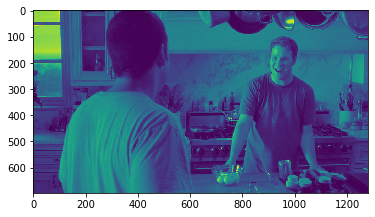

In [0]:
with open('/content/drive/My Drive/face_detection.json', 'r') as json_file:
    # print(len(json_file))
    for cnt, line in enumerate(json_file):
        if cnt ==1:
            data = json.loads(line)
            print(data['content'])
            print(data['annotation'])
            response = urllib.request.urlretrieve(data['content'])
            print(response)
            # data = response.read()
            img = Image.open(response[0]).convert('L')
            plt.imshow(np.asarray(img))
    print(cnt)

In [0]:
class FaceDataset(Dataset):
    def __init__(self, root='/content/drive/My Drive/face_detection.json'):
        self.root_dir = root
        self.image = []
        self.image_color = []
        self.annotation = []
        self.image_size = []
        # transforms
        self.transform_with_normalization = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],
                                     std=[0.5] )
                ])
        self.transform_resize = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor()
                ])
        # load image
        with open(root, 'r') as json_file:
            for cnt, line in enumerate(json_file):
                data = json.loads(line)
                # get the image from Internet
                response = urllib.request.urlretrieve(data['content'])
                img_color = Image.open(response[0])
                img = img_color.convert('L')
                self.image.append(img)
                self.image_color.append(img_color)

                for anno in data['annotation']:
                    self.annotation.append([(anno['points'][0]['x'], anno['points'][0]['x']), (anno['points'][1]['x'], anno['points'][1]['x'])])
                    self.image_size.append((anno['imageWidth'], anno['imageHeight']))

    def __len__(self):
        if self.aug:
            # one original image + 
            # 3 transfromed
            return len(self.image) * (len(self.trans_lst) + 1)
        else:
            return len(self.image)
                       
    def __getitem__(self, idx):
            image_trans = self.transform_resize(self.image[idx])
            mask_trans = self.transform_resize(self.mask[idx])
            return image_trans, mask_trans 

In [0]:
full_dataset = FaceDataset()

In [0]:
train_size = int(0.9 * len(full_dataset))
validation_size = int((len(full_dataset) - train_size) / 2)
test_size = len(full_dataset) - train_size - validation_size

train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, validation_size, test_size])

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_data_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=8, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

21


# MTCNN

In [0]:
!git clone https://github.com/opencv/opencv.git

Cloning into 'opencv'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 264029 (delta 0), reused 0 (delta 0), pack-reused 264027
Receiving objects: 100% (264029/264029), 464.64 MiB | 27.93 MiB/s, done.
Resolving deltas: 100% (184066/184066), done.
Checking out files: 100% (6119/6119), done.


2


True

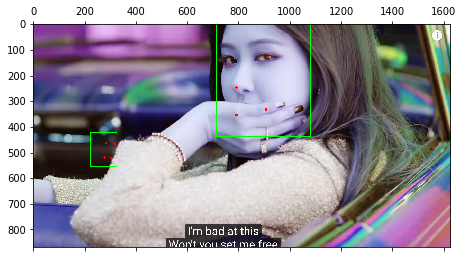

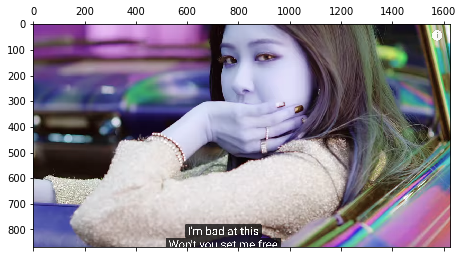

In [0]:
# initialise the detector class.
detector = MTCNN()
image_name = "Screen Shot 2019-12-02 at 9.57.57 PM.png"
# load an image as an array
image = cv2.imread(image_name)

# detect faces from input image.
face_locations = detector.detect_faces(image)
print(len(face_locations))
# draw bounding box and five facial landmarks of detected face
for face in zip(face_locations):
    (x, y, w, h) = face[0]['box']
    landmarks = face[0]['keypoints']
    # plt.matshow(image[y:y+h, x:x+w])
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
    
    for key, point in landmarks.items():
        cv2.circle(image, point, 2, (255, 0, 0), 6)

plt.matshow(image)
cv2.imwrite("/content/bpmtcnn.jpg", image)

##### haar
face_cascade = cv2.CascadeClassifier("/content/opencv/data/haarcascades/haarcascade_frontalface_default.xml")
# eye_cascade = cv2.CascadeClassifier("haarcascade_eye.xml")
img = cv2.imread(image_name)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# print(gray)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    # roi_gray = gray[y:y+h, x:x+w]
    # roi_color = img[y:y+h, x:x+w]
    # eyes = eye_cascade.detectMultiScale(roi_gray)
    # for (ex,ey,ew,eh) in eyes:
    #     cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.matshow(img)
cv2.imwrite("/content/bpcascade.jpg", img)
# cv2.imwrite("/content/drive/My Drive/bp4kdetected.jpg", image)

In [0]:
!pip install google_images_download
from google_images_download import google_images_download

!wget https://chromedriver.storage.googleapis.com/2.42/chromedriver_linux64.zip  && unzip chromedriver_linux64

     |████████████████████████████████| 911kB 4.0MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=14550 sha256=43feab4ebb2ff0149c191373423ef2bfbddc4b3e16c3527f0a8e575925f29679
  Stored in directory: /root/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download
--2019-12-01 17:50:32--  https://chromedriver.storage.googleapis.com/2.42/chromedriver_linux64.zip
Resolving chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)... 64.233.187.128, 2404:6800:4008:c05::80
Connecting to chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4039043 (3.9M) [application/zip]
Saving to: ‘chromedriver_linux64.zip’

chromedriver_linux6 100%[===================>]   3.85M  --.-KB/s    in 0.02s   

2019-12-01 17:50:33 (187 MB/s) - ‘chromedriver_linux64.

# Making Dataset for face recognition

## Retreive Image from web

In [0]:
!rm -rf downloads
GROUP_NAME = "BTS"

response = google_images_download.googleimagesdownload() 

search_queries = [
	                #  "BTS Jin", "BTS Suga", "BTS J-Hope", "BTS RM", "BTS Jimin", 
					             "BTS V", "BTS Jungkook"] 


def downloadimages(query): 
	# keywords is the search query 
	# format is the image file format 
	# limit is the number of images to be downloaded 
	# print urs is to print the image file url 
	# size is the image size which can 
	# be specified manually ("large, medium, icon") 
	# aspect ratio denotes the height width ratio 
	# of images to download. ("tall, square, wide, panoramic") 
	arguments = {"keywords": query, 
				"limit":101, 
				"print_urls":True, 
                "cd":"/content/chromedriver",
				"output_directory": "/content/drive/My Drive/BTS_downloads"} 
	try: 
		response.download(arguments) 
	
	# Handling File NotFound Error	 
	except FileNotFoundError: 
		arguments = {"keywords": query, 
					"format": "jpg", 
					"limit":4, 
					"print_urls":True, 
					"size": "medium",
                    "chromedriver":"/content/chromedriver"} 
					
		# Providing arguments for the searched query 
		try: 
			# Downloading the photos based 
			# on the given arguments 
			response.download(arguments) 
		except: 
			pass

# Driver Code 
for query in search_queries: 
	downloadimages(query) 
	print() 


In [0]:
image_lst = sorted(os.listdir("/content/downloads/BTS Jin/"))
print(image_lst)

In [0]:
%%shell
rm -rf "/content/drive/My Drive/BTS_faces"
cd "/content/drive/My Drive/"
mkdir BTS_faces

## Crop faces

In [0]:
detector = MTCNN()
downloads_folder = "/content/drive/My Drive/bp_downloads/"
faces_folder = "/content/drive/My Drive/BP_faces/"
member_lst = sorted(os.listdir(downloads_folder))
for idx, folder in enumerate(member_lst):
    image_lst = sorted(os.listdir(downloads_folder + folder + '/'))
    !cd "$faces_folder" && mkdir "$folder"
    for cnt, img in enumerate(image_lst):
        # if idx =  and cnt < 61:
        #     continue
        print("in folder: " + folder + " at idx: " + str(cnt))
        img_read = cv2.imread(downloads_folder + folder + '/' + img)
        if img_read is not None:

            face_locations = detector.detect_faces(img_read)
            if len(face_locations) != 1:
                print("not one face detected, number of faces: "+ str(len(face_locations)) + "on image: " + img)
            else: 
                (x, y, w, h) = face_locations[0]['box']
                #     landmarks = face[0]['keypoints']
                if x >= 0 and y >=0:
                #     cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
                    
                #     for key, point in landmarks.items():
                #         cv2.circle(image, point, 2, (255, 0, 0), 6)
                    ret = cv2.imwrite(faces_folder + folder + '/' + str(cnt) + ".jpg", img_read[y:y+h, x:x+w])
                    if not ret:
                        print("image save failed!")
                else:
                    print("negative face found")
        else:
            print("imread failed on " + img)

mkdir: cannot create directory ‘.ipynb_checkpoints’: File exists
mkdir: cannot create directory ‘Blackpink Lisa’: File exists
in folder: Blackpink Lisa at idx: 0
in folder: Blackpink Lisa at idx: 1
in folder: Blackpink Lisa at idx: 2
in folder: Blackpink Lisa at idx: 3
in folder: Blackpink Lisa at idx: 4
in folder: Blackpink Lisa at idx: 5
in folder: Blackpink Lisa at idx: 6
in folder: Blackpink Lisa at idx: 7
not one face detected, number of faces: 0on image: 105.8526494bda9c1a39e49af8264bbad2fccdaee901_hq.jpg
in folder: Blackpink Lisa at idx: 8
not one face detected, number of faces: 3on image: 106.BLACKPINK-Lisa-Steals-The-Limelight-At-Paris-Mens-Fashion-Week.jpg
in folder: Blackpink Lisa at idx: 9
in folder: Blackpink Lisa at idx: 10
in folder: Blackpink Lisa at idx: 11
not one face detected, number of faces: 0on image: 109.blackpink-lisa1379845-prints.jpg
in folder: Blackpink Lisa at idx: 12
not one face detected, number of faces: 2on image: 11.bambamlisa.jpg
in folder: Blackpink 

##visualize dataset

In [0]:
def compose(lst, r, c):
    assert len(lst) == r * c 
    image = np.array([])
    for i in range(r):
        row = np.array([])
        for j in range(c):
            idx = (j + 1) * (i + 1) - 1
            if j == 0:
                row = lst[idx]
            else:
                row = np.concatenate((row, lst[idx]), axis=1)
        if i == 0:
            image = row
        else:
            image = np.concatenate((image, row), axis=0)
    return image
transform_resize = transforms.Compose([
                transforms.Resize((50, 50)),
                transforms.ToTensor(),
                prewhiten
                ])
lst = []
catagories = sorted(os.listdir("/content/drive/My Drive/BP_faces/"))
for cnt, member in tqdm(enumerate(catagories)):
    print("member name: " + member + ", Catagory: " + str(cnt))
    img_lst = sorted(os.listdir("/content/drive/My Drive/BP_faces/" + member + '/'))
    sub_lst = []
    for img in tqdm(img_lst):
        if img.endswith(".jpg"):
            pil_img = Image.open("/content/drive/My Drive/BP_faces/" + member + '/' + img)
            tensor = transform_resize(pil_img)
            swp = np.swapaxes(np.asarray(tensor), 0, 1)
            swp = np.swapaxes(swp, 1, 2)
            # print(swp.shape)
            # plt.matshow(swp)
            # resized = cv2.resize(cv2.imread("/content/drive/My Drive/BP_faces/" + member + '/' + img), (50,50))
            # tensor = torch.from_numpy(resized)
            # whiten = prewhiten(tensor)
            sub_lst.append(swp)
    lst.append(sub_lst)

            

0it [00:00, ?it/s]
0it [00:00, ?it/s]

 10%|▉         | 24/250 [00:00<00:00, 232.96it/s]

member name: .ipynb_checkpoints, Catagory: 0
member name: Jennie, Catagory: 1



100%|██████████| 250/250 [01:11<00:00,  3.01it/s]
2it [01:11, 35.61s/it]
  0%|          | 0/241 [00:00<?, ?it/s]

member name: Jisoo, Catagory: 2



100%|██████████| 241/241 [01:24<00:00,  2.75it/s]
3it [02:35, 50.34s/it]
  0%|          | 0/219 [00:00<?, ?it/s]

member name: Lisa, Catagory: 3



100%|██████████| 219/219 [01:16<00:00,  3.04it/s]
4it [03:52, 58.10s/it]
  0%|          | 0/268 [00:00<?, ?it/s]

member name: Rose, Catagory: 4



100%|██████████| 268/268 [01:33<00:00,  3.02it/s]
5it [05:25, 68.61s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


250
268
(700, 750, 3)


True

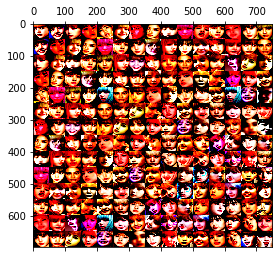

In [0]:
print(len(lst[1]))
print(len(lst[4]))
outimg = compose(lst[3][:210], 14 ,15)
print(outimg.shape)
plt.matshow(outimg)
cv2.imwrite("/content/lisagridwhiten.jpg", outimg)